**Predict California Housing Prices with TensorFlow**

*Step 1: Import Python Packages*

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import math
import shutil
from IPython.core import display as ICD

*Step 2: Perform Basic Matrix Operations Using TensorFlow*

In [2]:
# Matrix addition with Numpy
a = np.array([4, 3, 6])
b = np.array([3, -1, 2])
c = np.add(a, b)
print(c)
# Matrix addition with TensorFlow
a = tf.constant([4, 3, 6])
b = tf.constant([3, -1, 2])
c = tf.add(a, b)
with tf.Session() as sess:
  result = sess.run(c)
  print(result)

[7 2 8]
[7 2 8]


*Step 3: Load and Describe Data*

In [3]:
df = pd.read_csv("../input/housing.csv", sep=",")
print('Original Dataset:')
ICD.display(df.head(15))
a = pd.DataFrame(df.isnull().sum())
a['# of null values'] = a[0]
b = a[['# of null values']]
print('Before Dropping Null Values:')
print('# of Rows, Columns: ',df.shape)
ICD.display(b)
df = df.dropna(axis=0)
a = pd.DataFrame(df.isnull().sum())
a['# of null values'] = a[0]
b = a[['# of null values']]
print('After Dropping Null Values:')
print('# of Rows, Columns: ',df.shape)
ICD.display(b)

Original Dataset:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


Before Dropping Null Values:
# of Rows, Columns:  (20640, 10)


,# of null values
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,207
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


After Dropping Null Values:
# of Rows, Columns:  (20433, 10)


,# of null values
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,0
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


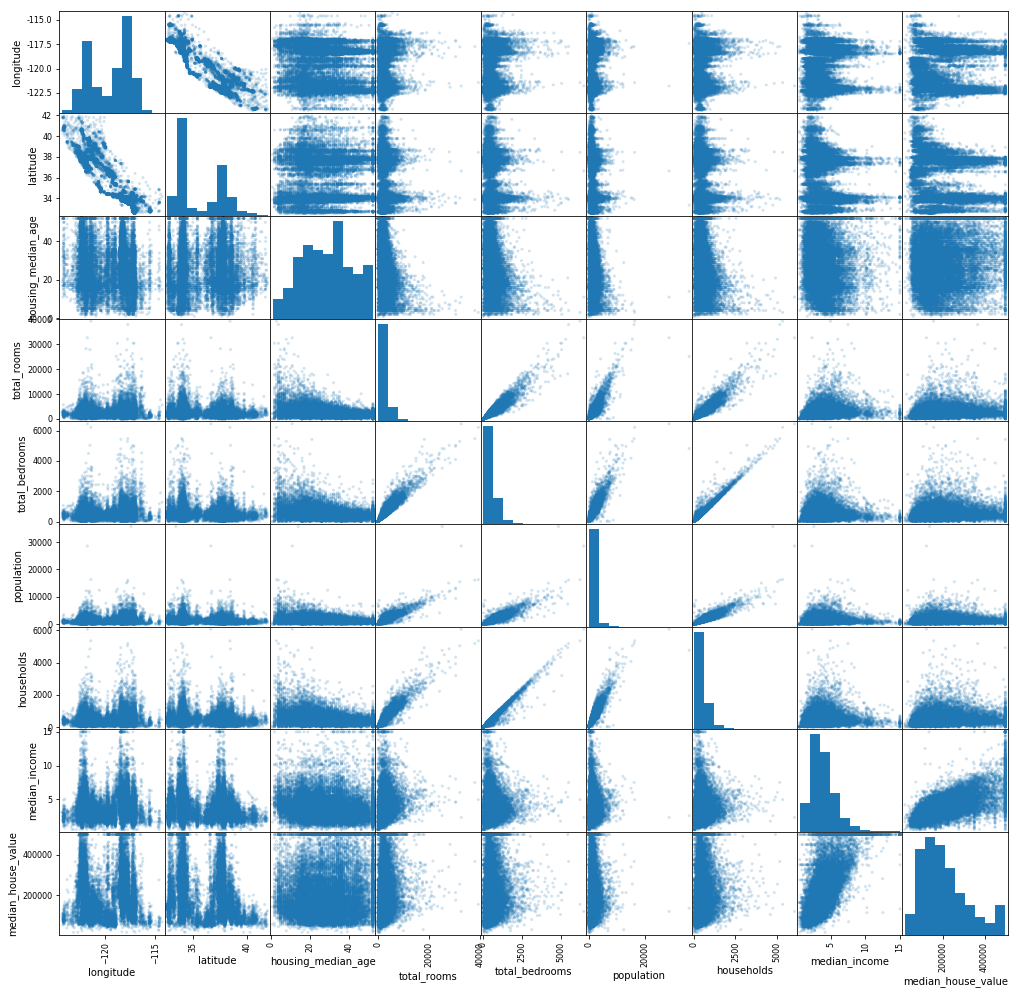

In [4]:
c = pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(17, 17), diagonal='hist')
c;

*Step 4: Feature Engineering*

In [5]:
df['num_rooms'] = df['total_rooms'] / df['households']
df['num_bedrooms'] = df['total_bedrooms'] / df['households']
df['persons_per_house'] = df['population'] / df['households']
df.drop(['total_rooms', 'total_bedrooms', 'population', 'households'], axis = 1, inplace = True)

featcols = {
  colname : tf.feature_column.numeric_column(colname) \
    for colname in 'housing_median_age,median_income,num_rooms,num_bedrooms,persons_per_house'.split(',')
}
# Bucketize lat, lon so it's not so high-res; California is mostly N-S, so more lats than lons
featcols['longitude'] = tf.feature_column.bucketized_column(tf.feature_column.numeric_column('longitude'),
                                                   np.linspace(-124.3, -114.3, 5).tolist())
featcols['latitude'] = tf.feature_column.bucketized_column(tf.feature_column.numeric_column('latitude'),
                                                  np.linspace(32.5, 42, 10).tolist())

# Split into train and eval
msk = np.random.rand(len(df)) < 0.8
traindf = df[msk]
evaldf = df[~msk]

SCALE = 100000
BATCH_SIZE=100
train_input_fn = tf.estimator.inputs.pandas_input_fn(x = traindf[list(featcols.keys())],
                                                    y = traindf["median_house_value"] / SCALE,
                                                    num_epochs = 1,
                                                    batch_size = BATCH_SIZE,
                                                    shuffle = True)
eval_input_fn = tf.estimator.inputs.pandas_input_fn(x = evaldf[list(featcols.keys())],
                                                    y = evaldf["median_house_value"] / SCALE,  # note the scaling
                                                    num_epochs = 1, 
                                                    batch_size = len(evaldf), 
                                                    shuffle=False)
print('# of Rows, Columns: ',df.shape)
ICD.display(df.head(15))

# of Rows, Columns:  (20433, 9)


,longitude,latitude,housing_median_age,median_income,median_house_value,ocean_proximity,num_rooms,num_bedrooms,persons_per_house
0,-122.23,37.88,41.0,8.3252,452600.0,NEAR BAY,6.984127,1.023810,2.555556
1,-122.22,37.86,21.0,8.3014,358500.0,NEAR BAY,6.238137,0.971880,2.109842
2,-122.24,37.85,52.0,7.2574,352100.0,NEAR BAY,8.288136,1.073446,2.802260
3,-122.25,37.85,52.0,5.6431,341300.0,NEAR BAY,5.817352,1.073059,2.547945
4,-122.25,37.85,52.0,3.8462,342200.0,NEAR BAY,6.281853,1.081081,2.181467
5,-122.25,37.85,52.0,4.0368,269700.0,NEAR BAY,4.761658,1.103627,2.139896
6,-122.25,37.84,52.0,3.6591,299200.0,NEAR BAY,4.931907,0.951362,2.128405
7,-122.25,37.84,52.0,3.1200,241400.0,NEAR BAY,4.797527,1.061824,1.788253
8,-122.26,37.84,42.0,2.0804,226700.0,NEAR BAY,4.294118,1.117647,2.026891
9,-122.25,37.84,52.0,3.6912,261100.0,NEAR BAY,4.970588,0.990196,2.172269


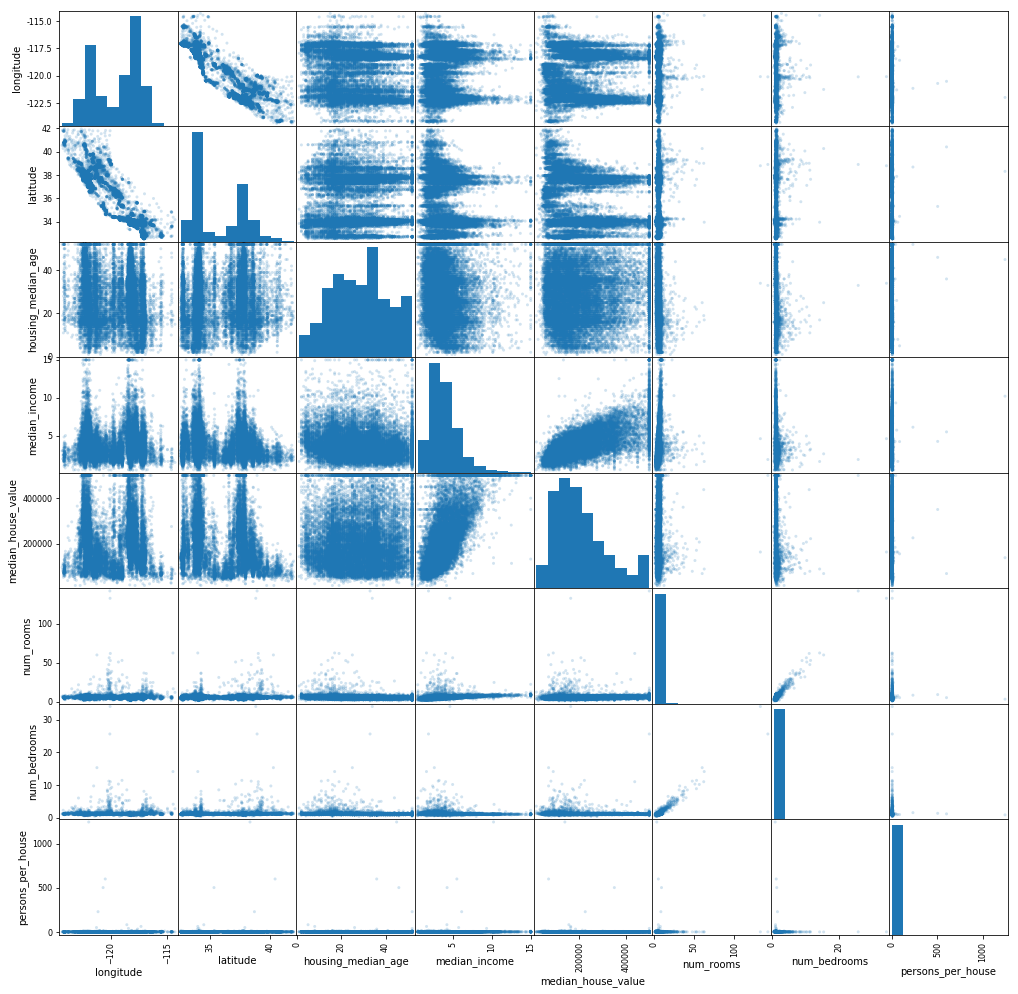

In [6]:
c = pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(17, 17), diagonal='hist')
c;

*Step 5: Evaluate Regressors Using a Reduced Feature Space*

In [7]:
def print_rmse(model, name, input_fn):
  metrics = model.evaluate(input_fn=input_fn, steps=1)
  print ('RMSE on {} dataset = {} USD'.format(name, np.sqrt(metrics['average_loss'])*SCALE))

[LinearRegressor()](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearRegressor) with only a single feature (num_rooms).

In [8]:
SCALE = 100000
train_fn = tf.estimator.inputs.pandas_input_fn(x = df[["num_rooms"]],
                                              y = df["median_house_value"] / SCALE,  # note the scaling
                                              num_epochs = 1,
                                              shuffle = True)

features = [tf.feature_column.numeric_column('num_rooms')]
outdir = './housing_trained'
shutil.rmtree(outdir, ignore_errors = True) # start fresh each time
myopt = tf.train.AdamOptimizer(learning_rate = 0.01)
model = tf.estimator.LinearRegressor(model_dir = outdir, feature_columns = features, optimizer = myopt)
model.train(input_fn = train_fn, steps = 300)
print_rmse(model, 'training', train_fn)

RMSE on training dataset = 101133.5015296936 USD


[DNNRegressor()](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNRegressor) with only a single feature (num_rooms).

In [9]:
SCALE = 100000
train_fn = tf.estimator.inputs.pandas_input_fn(x = df[["num_rooms"]],
                                              y = df["median_house_value"] / SCALE,  # note the scaling
                                              num_epochs = 1,
                                              shuffle = True)

features = [tf.feature_column.numeric_column('num_rooms')]
outdir = './housing_trained'
shutil.rmtree(outdir, ignore_errors = True) # start fresh each time
myopt = tf.train.AdamOptimizer(learning_rate = 0.03)
model = tf.estimator.DNNRegressor(model_dir = outdir,
                                hidden_units = [50, 50, 20],
                                feature_columns = features,
                                optimizer = myopt,
                                dropout = 0.05)
model.train(input_fn = train_fn, steps = 300)
print_rmse(model, 'training', train_fn)

RMSE on training dataset = 125025.21276473999 USD


*Step 6: Evaluate Regressors Using the Full Feature Space*

[LinearRegressor()](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearRegressor) using the full feature space.

In [10]:
outdir = './housing_trained'
shutil.rmtree(outdir, ignore_errors = True) # start fresh each time
myopt = tf.train.AdamOptimizer(learning_rate = 0.01)
model = tf.estimator.LinearRegressor(model_dir = outdir, feature_columns = featcols.values(), optimizer = myopt)
#NSTEPS = (100 * len(traindf)) / BATCH_SIZE
NSTEPS = 3000
model.train(input_fn = train_input_fn, steps = NSTEPS)
print_rmse(model, 'eval', eval_input_fn)

RMSE on eval dataset = 94435.29844284058 USD


[DNNRegressor()](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNRegressor) using the full feature space.

In [11]:
outdir = './housing_trained'
shutil.rmtree(outdir, ignore_errors = True) # start fresh each time
myopt = tf.train.AdamOptimizer(learning_rate = 0.01)
model = tf.estimator.DNNRegressor(model_dir = outdir,
                                hidden_units = [50, 50, 20],
                                feature_columns = featcols.values(),
                                optimizer = myopt,
                                dropout = 0.1)
#NSTEPS = (100 * len(traindf)) / BATCH_SIZE
NSTEPS = 3000
model.train(input_fn = train_input_fn, steps = NSTEPS)
print_rmse(model, 'eval', eval_input_fn)

RMSE on eval dataset = 103768.47982406616 USD


**Summary:
**

In the end, we were able to predict California housing prices using a TensorFlow DNNRegressor and we saw an error (RMSE) of approximately $80,000.  In the future, I will optimize the model hyper-parameters and I will add additional evaluation metrics in order to make these predictions more accurate.

Credit: Many of these functions are adaptations from the following tutorials ([Link #1](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive/03_tensorflow/a_tfstart.ipynb), [Link #2](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive/05_artandscience/a_handtuning.ipynb), [Link #3](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive/05_artandscience/c_neuralnetwork.ipynb)).